<a href="https://colab.research.google.com/github/Rogerio-mack/fNIRS/blob/main/MB99_review_loadMNE_x_MyTables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install & import `nilearn` and `mne-nirs`

In [1]:
#@markdown
!pip install nilearn
!pip install -U --no-deps https://github.com/mne-tools/mne-python/archive/main.zip
!pip install mne-nirs

from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne 



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 9.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     | 61.5 MB 186 kB/s
  Created wheel for mne: filename=mne-1.1.dev0-py3-none-any.whl size=7434596 sha256=07cc72107b12b703f75c83a594f2191597accab2f6d7b80350f008b8468d28f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-1e_dx57z/wheels/66/fc/d2/9d32190e71b475

## Mount Google Drive

In [2]:
#@markdown
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Common Imports

In [3]:
#@markdown 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

import h5py
from itertools import compress
from sklearn.preprocessing import scale
from google.colab import widgets

## Routines

In [4]:
#@markdown `def clone_snirf(path_in, path_out, fname='out.snirf')`
def clone_snirf(path_in, path_out, fname='out.snirf'):
  
  if path_in == path_out:
    print('Error: path_in and path_out can not be the same.') 
    return

  if not os.path.exists(path_out):
      os.mkdir(path_out)
      print("Directory " , path_out ,  "was created")
  else:    
      print("Warning: directory " , path_out ,  " already exists")

  if os.path.exists(path_out + fname):
    os.remove(path_out + fname)
    print('Warning: previous output file was deleted.')
  
  print('Input snirf file: ' + path_in + fname)

  fs = h5py.File(path_in + fname,'r')
  fd = h5py.File(path_out + fname,'w')

  if list(fs.keys()).count('formatVersion') >= 1:
    fs.copy('formatVersion',fd,'formatVersion') 
  else:
    print('Warning: there is no formatVersion key in snirf input.')

  if list(fs.keys()).count('nirs') >= 1:
    fs.copy('nirs',fd,'nirs') 
  else:
    print('Error: Invalid snirf file. There is no nirs key in snirf input.')  
  
  print('Output snirf file: ' + path_out + fname)
  
  fd.close()
  fs.close()

  return

In [5]:
#@markdown `def create_channels_table(data,reorder=False)`
def create_channels_table(data,reorder=False):

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # Parameters: 
  # data: snirf file read

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    print(exp)
    exec(exp)
    
  nr_measurements = len([ x for x in list( data1.keys() ) if 'measurementList' in x ])+1
  measurements = ['measurementList' + str(x) for x in np.arange(1,nr_measurements)] 
  # print(measurements)

  measure_idx = []
  name = []
  source =  []
  detector = []
  source_pos = []
  detector_pos = []
  source_pos_3D = []
  detector_pos_3D = []
  flag_2D = True
  flag_3D = True
  frequencies = []

  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    e_source = int(data1[m]['sourceIndex'][0])   
    e_detector = int(data1[m]['detectorIndex'][0]) 
    
    if list(probe.keys()).count('sourcePos2D') > 0 and list(probe.keys()).count('detectorPos2D') > 0: 
      e_source_pos = probe['sourcePos2D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos = probe['detectorPos2D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_2D = False
      e_source_pos = e_detector_pos = np.array([0,0],dtype=float)

    # e_frequencies = probe['frequencies'][0]

    if list(probe.keys()).count('sourcePos3D') > 0 and list(probe.keys()).count('detectorPos3D') > 0:
      e_source_pos_3D = probe['sourcePos3D'][ int(data1[m]['sourceIndex'][0]) - 1 ] # .decode('UTF-8')
      e_detector_pos_3D = probe['detectorPos3D'][ int(data1[m]['detectorIndex'][0]) - 1 ] # .decode('UTF-8')
    else:
      flag_3D = False
      e_source_pos_3D = e_detector_pos_3D = np.array([0,0,0],dtype=float)

    name.append( e_name )
    source.append( e_source )
    detector.append( e_detector )
    source_pos.append( e_source_pos )
    detector_pos.append( e_detector_pos )
  #  frequencies.append( e_frequencies )
    source_pos_3D.append( e_source_pos_3D )
    detector_pos_3D.append( e_detector_pos_3D )

  if not flag_2D:
    print('WARNING: no source, detector pos 2D available\n')

  if not flag_3D:
    print('WARNING: no source, detector pos 3D available\n')

  # print(measure_idx)  
  # print(name)  
  # print(source)
  # print(detector)
  # print(source_pos)
  # print(detector_pos)
  # print(frequencies)
  # print(source_pos_3D)
  # print(detector_pos_3D)

  measures = pd.DataFrame({'measure_idx':measure_idx,
                          'name':name,
                          'source':source,
                          'detector':detector,
  #                         'frequencies':frequencies,
                          'source_pos':source_pos,
                          'detector_pos':detector_pos,
                          'source_pos_3D':source_pos_3D,
                          'detector_pos_3d':detector_pos_3D}) # .sort_values('measure_idx').reset_index(drop=True)
  # measures.head()

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  # wavelength
  measures['wavelength'] = wavelength 
  measures['name'] = measures['name'] + '_' + wavelength 
  measures.set_index('measure_idx',inplace=True) 

  measures = measures[['name', 'source', 'detector', 'wavelength', 'source_pos', 'detector_pos',
        'source_pos_3D', 'detector_pos_3d']]
  measures = measures.rename_axis('')
  measures.head()

  if reorder:
    measures = measures.sort_values('name')

  return measures.reset_index(drop=True)




In [6]:
#@markdown `def create_channels_raw(data,reorder=False)`
def create_channels_raw(data,reorder=False):

  # Parameters: 
  # data: snirf file read

  if reorder:
    print('Warning: reorder=True puts channels names in ascendent order, but this can be a different order from snirf file.')

  # create alias for all data['nirs'].keys()
  for key in data['nirs'].keys():
    exp = key + ' = data["nirs"]["' + key + '"] '
    exec(exp)

  nr_measurements = len([ x for x in list( data1.keys() ) if 'measurementList' in x ])+1
  measurements = ['measurementList' + str(x) for x in np.arange(1,nr_measurements)] 

  measure_idx = []
  name = [] 
  for m in measurements:
    measure_idx.append( int( m[ len('measurementList'):: ] ) )
    e_name = probe['sourceLabels'][ int(data1[m]['sourceIndex'][0]) - 1 ].decode('UTF-8') + '_' + probe['detectorLabels'][ int(data1[m]['detectorIndex'][0]) - 1 ].decode('UTF-8') 
    name.append( e_name )

  measures = pd.DataFrame({'name':name})

  wavelength = []

  for m in measurements:
    wavelength.append( str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ])) )
  #  print( m,str(int(probe['wavelengths'][ int(data1[m]['wavelengthIndex'][0]) - 1 ]))  )

  measures['name'] = measures['name'] + '_' + wavelength 

  # print(measures)

  raw = pd.concat([pd.DataFrame(data1['time']), pd.DataFrame(data1['dataTimeSeries'])], axis=1)
  raw.columns = ['time'] + list(measures.name) 
  
  if reorder:
    df_temp = raw.drop(columns='time')
    df_temp = df_temp.reindex(sorted(df_temp.columns), axis=1)
    df_temp = pd.concat([raw.time,df_temp], axis=1 )
    raw = df_temp 

  return raw

In [7]:
#@markdown `def normalize_channels(df)`
def normalize_channels(df):
  df_scaled = df.drop(columns='time').copy()
  
  for c in df_scaled:
    df_scaled[c] = scale( df_scaled[c] )

  df_scaled = pd.concat([df.time,df_scaled],axis=1)
  return df_scaled 

# normalize_channels(channels_raw)

In [8]:
#@markdown `def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25)`
def plotchannels_all(df, reds=True, normalize=False, figsize=(20,16), cv_threshold=0.25):

  f = plt.figure( figsize=figsize )

  if normalize:
    df_not_scaled = df.copy()
    df = normalize_channels(df)
  else:
    df_not_scaled = df # the same

  inicio = 0  
  inc = 6
  add_inc = 0
  ticks = []

  col_order = df.drop(columns='time').columns.sort_values()

  for c in col_order:
    if not reds:
      sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc )
    else:
      if df_not_scaled[c].min() < 0:
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color='r', alpha=0.8)
      else:
        if df_not_scaled[c].mean() != 0:
          cv = df_not_scaled[c].std() / df_not_scaled[c].mean()
        else:
          cv = 0
        sns.lineplot( x=df['time'], y=df[c] + inicio + add_inc, color=['gray','yellow'][cv > cv_threshold or cv == 0], alpha=[0.5,0.8][cv > cv_threshold or cv == 0])

    ticks.append(inicio + add_inc)
    add_inc = add_inc + inc
    
  ylim = f.gca().get_ylim()[1]

  # for c in group_nirs['group']['stimulus'].drop(columns='time'):
  #  plt.plot(stimulus['time'],stimulus[c]*ylim,label=c,lw=1,linestyle='dashed')

  # plt.legend()
  if normalize:
    plt.yticks(ticks = ticks, labels = list( col_order ))
    plt.ylabel('')
  else:
    plt.ylabel('Channel Values')

  plt.show()

  return 

# plotchannels_all(channels_raw)
# plotchannels_all(channels_raw,normalize=True,figsize=(10,10))


In [9]:
#@markdown `def check_sample_rate(df)`
def check_sample_rate(df):

  sample_rate = np.float(df.time[-1:] / len(df.time))
  print('Sample rate: ', sample_rate, 'in sec.')

  total_time =  df.time[-1:].values[0]
  print('Total time: ',   total_time , 'in sec.')

  resample = None 

  if not all( channels_raw.time.diff()[1::]*10 == channels_raw.time.diff()[1]*10 ):
    print('Warning: time seems have different intervals. For better signal processing sample rate should be constant. Try to check and correct this.')
    print('Sample rate suggested: 0.1 sec (for this, you can use time values of the third return of this function)')

    resample_time = np.round( np.arange(0,len(df),1)/10 , 1)

  return sample_rate, total_time, resample_time

# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

# to change...
# channels_raw.time = resample_time
# sample_rate, total_time, resample_time = check_sample_rate(channels_raw)

In [10]:
#@markdown `def perc_negatives(s_neg)`
def perc_negatives(s_neg):
#
# Parameters:
# s_neg: np.array with negatives values
#
# Returns:
# perc_neg: % of negatives values
#
# Test:
# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  return len( np.array(np.where( s_neg < 0 )).ravel() ) / len(s_neg)

# perc_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

# channels_raw.drop(columns='time').apply(perc_negatives) 

In [11]:
#@markdown `def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25)`
# from matplotlib import pylab
from google.colab import widgets

def plotchannels_tab(df, reds=False, threshold_neg = 0.10, all=True, normalized=True, statistics=True, individuals=True,  cv_threshold=0.25):

  chnames = df.drop(columns='time').columns.sort_values()

  if individuals:
    tabnames = chnames.to_list()

    # Mark tabnames with '()' for channels with negative values
    for i in range(len(tabnames)):
      if df[ tabnames[i] ].min() < 0:
        tabnames[i] = '(' + tabnames[i] + ')'
  else:
    tabnames = []

  # Add other tabs
  before = 0
  
  if normalized:
    tabnames = ['Normalized'] + tabnames 
    before = before + 1

  if all:
    tabnames = ['All'] + tabnames 
    before = before + 1

  if statistics:
    tabnames = tabnames + ['Statistics']

  tb = widgets.TabBar(tabnames)

  if all:
    with tb.output_to(tabnames.index('All')):
      plotchannels_all(df,reds=True)

  if normalized:
    with tb.output_to(tabnames.index('Normalized')):
      plotchannels_all(df,reds=True,normalize=True)

  if individuals:
    for i in range(len(chnames)):
      # Only select the first 2 tabs, and render others in the background.
      with tb.output_to(i+before, select=(i+before < before)): # +2 because ['All','Normalized']
        if reds:
          if df[chnames[i]].min() < 0:          
            plt.plot(df.time, df[chnames[i]], color=['blue','red'][df[chnames[i]].min() < 0] )
          else:
            if df[chnames[i]].mean() != 0:
              cv = df[chnames[i]].std() / df[chnames[i]].mean()
            else:
              cv = 0  
            plt.plot(df.time, df[chnames[i]], color=['blue','yellow'][cv > cv_threshold or cv == 0] )
        else:
          plt.plot(df.time, df[chnames[i]], color='blue')

  if statistics:
    with tb.output_to(tabnames.index('Statistics'),select=0):
      display( df.drop(columns='time').describe() )
      print()

      neg_true = df.drop(columns='time').apply(min) < 0  

      if any(neg_true):
        print('Warning: There are negative values in signals.')

      for c in neg_true[ neg_true == True ].index:
        if perc_negatives(df[c]) > threshold_neg:
          print(c,'\t...had negative values over ', threshold_neg, ' rate, values should be rescaled to positive')
        else:
          print(c,'\t...had negative values, values should be interpolated')

      print('Warning: Just check sample rate here.')
      check_sample_rate(df)

      print()
      print('Coeficientes de Variação, Threshold = ', cv_threshold, ' e Presença de Valores Negativos')
      
      cv_list = [] # 0 for channels with all values 0 (invalid)
      for c in channels_raw.drop(columns = 'time'):
        if channels_raw.drop(columns = 'time')[c].mean() != 0:
          cv_list.append( channels_raw.drop(columns = 'time')[c].std() / channels_raw.drop(columns = 'time')[c].mean() )
        else:
          cv_list.append(0)  
      df_cv = pd.DataFrame( channels_raw.drop(columns = 'time').std() ) # just to inicialize df
      df_cv.rename(columns={0:'coef_var'},inplace=True)
      df_cv['coef_var'] = cv_list # replace with real cvs
      df_cv['up_threshold'] = df_cv['coef_var'] > cv_threshold
      df_cv['negative_values'] = channels_raw.drop(columns = 'time').min() < 0
      print(df_cv)

      print()
      print('*Coeficientes de Variação é válido somente para valores positivos')

  return



In [12]:
#@markdown `def interpolate_negatives(s_neg, threshold_neg = 0.10)`
def interpolate_negatives(s_neg, threshold_neg = 0.10):
#
# Parameters:
# s_neg: np.array with less than threshold_neg of negatives values to be interpolate
# threshold_neg: 0.10
#
# Returns:
# s_pos: np.array with values interpolated
#
# Test:
# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))
#
  if perc_negatives(s_neg) > threshold_neg:
    print(c,'Error: there are more negative values than threshold_neg. You can try rerun with a different threshold.')
    return None

  xp = np.array(np.where( s_neg >= 0 )).ravel()
  fp = s_neg[ s_neg >= 0 ]
  x = np.array(np.where( s_neg < 0 )).ravel()
  s_new = np.interp(x, xp, fp)

  s_pos = s_neg.copy()
  s_pos[ s_pos < 0 ] = s_new

  return s_pos

# interpolate_negatives(np.array([1,2,-1,5,5,7,-1,-1,10],dtype='float'))

In [13]:
#@markdown `def rectify_negatives(df, threshold_neg = 0.10, transform='zeros')`
def rectify_negatives(df, threshold_neg = 0.10, transform='zeros'):
 
  neg_true = df.drop(columns='time').apply(min) < 0  

  rectified_negatives = neg_true[ neg_true == True ].index

  for c in rectified_negatives:
    if perc_negatives(df[c]) > threshold_neg:
      if transform == 'zeros':
        df[c] = 0
        print(c,'\t...had values transformed to zeros')
      elif transform == 'positive':
        df[c] = df[c] + np.abs(df[c].min())
        print(c,'\t...had values rescaled to positive')  
      else:
        print('parameter transform erro. Only transforms negatives values to "zeros" or "positive" available up to now')  
    else:
      df[c] = interpolate_negatives(np.array(df[c]))
      print(c,'\t...had negative values interpolated')

  return df, list(rectified_negatives)



In [14]:
#@markdown `def add_appname_snirf(data, appname='snirf-Mack')`
def add_appname_snirf(data, appname='snirf-Mack'):

  data1 = data['nirs']['data1'] 

  if list(metaDataTags.keys()).count('AppName') == 1:
    metaDataTags['AppName'][...] = [appname]
  else:
    metaDataTags['AppName'] = np.array([appname],dtype='|S13')

  return


In [15]:
#@markdown `def rectify_negatives_snirf(data, channels_raw, rectified_negatives)` 
def rectify_negatives_snirf(data, channels_raw, rectified_negatives):

  data1 = data['nirs']['data1'] 

  for c in rectified_negatives:
  # print( c, list(channels_raw.columns).index(c) - 1 )
  # print( data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] )
  # print( any(data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] < 0) )   
    data1['dataTimeSeries'][:, list(channels_raw.columns).index(c) - 1 ] = channels_raw[c]  

  return



In [16]:
#@markdown `def rectify_time_snirf(data, channels_raw)`
def rectify_time_snirf(data, channels_raw):

  data1 = data['nirs']['data1'] 

  data1['time'][...] = channels_raw.time
  # print( data1['time'][...] )

  return

In [17]:
#@markdown `def create_stim_from_aux(data,delete_before=False,show=None)`
def create_stim_from_aux(data,delete_before=False,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) > 0 and delete_before:
    for s in stim_list:
      del data['nirs'][s]
      print('Warning: previous stim record ' + s + ' was deleted.')

  if len(stim_list) > 0 and not delete_before:
    print('Error: previous stim records ', stim_list,  ' should be deleted before create stim from aux.')
    return

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 
    
#  for a in aux_list:
#    print( data['nirs'][a].keys() )

  stim_aux = False

  for a in aux_list:
    if list(data['nirs'][a].keys()) == ['dataTimeSeries', 'name', 'time', 'timeOffset']: 
      stim_aux = True

  if not stim_aux:
    print('Error: it seems there is no valid aux stim records.')
    return
  else:
    print('Warning: trying to use aux stim records for stimulus. At least one record with dataTimeSeries, name, time and timeOffset.') 

  for a in aux_list:
    data['nirs'][a]['time'][...] = data1['time'][:] # ajusta o tempo
    data['nirs'][a]['dataTimeSeries'][:] = np.round(   data['nirs'][a]['dataTimeSeries'][:], 0) # ajusta o impulso

  for a in aux_list:
    stim = 'stim' + a.split('aux')[1]
    data['nirs'].create_group(stim)
    data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][a]['name'][0]]).astype('|O'))

    start = []
    end = []
    value = []

    start_bool = False

    for i in range( len( aux1['dataTimeSeries'] ) ):
      if data['nirs'][a]['dataTimeSeries'][i] != 0 and not start_bool:
        value.append( data['nirs'][a]['dataTimeSeries'][i] )
        start.append( data['nirs'][a]['time'][i] )
        start_bool = True
      else: 
        if data['nirs'][a]['dataTimeSeries'][i] == 0 and start_bool:  
          end.append( data['nirs'][a]['time'][i-1] )
          start_bool = False

    data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

  for a in aux_list:
    if data['nirs'][a]['timeOffset'][0] != 0:
      print('Warning: aux record ' + a + ' with timeOffset different from 0. timeOffset will be ignored when transformed to stim records.')

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  
  print('Stim records was created: ', stim_list)

  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return 
  




In [18]:
#@markdown `def plot_aux_stimulus(data)`
def plot_aux_stimulus(data):

  aux_list = [x for x in list(data['nirs'].keys()) if x.find('aux') == 0]
  if len(aux_list) == 0:
    print('Error: there is no aux records in data.')
    return 

  f = plt.figure(figsize=(20,4))

  for a in aux_list:
    plt.plot(data['nirs']['data1']['time'][:], data['nirs'][a]['dataTimeSeries'][:],label=a)

  plt.legend()
  plt.show()

  return

In [19]:
#@markdown `def rectify_stim_duration(data,duration=5,show=None)`
def rectify_stim_duration(data,duration=5,show=None):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  for s in stim_list:
    data['nirs'][s]['data'][:,1] = np.ones( data['nirs'][s]['data'].shape[0] )*duration
  
  if show != None:
    print('Showing stim record ', show, '...')
    print(data['nirs'][show]['name'][0])
    print(data['nirs'][show]['data'][:])

  return

In [20]:
#@markdown `def create_stim_rest(data,show=True)`
def create_stim_rest(data,show=True):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]

  if (len(stim_list)) == 0:
    print('Error: there is no stim records in data.')
    return

  stim = 'stim' + str( len(stim_list)+1 )
  data['nirs'].create_group(stim)
  data['nirs'][stim].create_dataset('name', data=np.array(['rest']).astype('|O'))

  start = []
  start_stim = []
  end = []
  value = []

  start_bool = False

  for s in stim_list:
    for i in range( data['nirs'][s]['data'].shape[0] ):
      start_stim.append( data['nirs'][s]['data'][i,0] )
      start.append( data['nirs'][s]['data'][i,0] + data['nirs'][s]['data'][i,1] )
      value.append(-1)

  start_stim = sorted(start_stim)
  start = sorted(start)

  for i in range(len(start_stim) - 1):
    end.append( start_stim[i+1] )

  start = start[0:-1]
  value = value[0:-1]

  data['nirs'][stim].create_dataset('data', data=np.array( [np.array(start) , np.array(end) - np.array(start) , np.array(value)] ).T)

# print(start)
# print(end)
# print(start_stim)
# print(value)

  if show:
    print('Showing stim record ', stim, ' created for rest...')
    print(data['nirs'][stim]['name'][0])
    print(data['nirs'][stim]['data'][:])

  return


In [21]:
#@markdown `def plot_stim_stimulus(data)`
def plot_stim_stimulus(data):

  stim_list = [x for x in list(data['nirs'].keys()) if x.find('stim') == 0]
  if len(stim_list) == 0:
    print('Error: there is no stim records in data.')
    return 
    
  stim_name_set = set() 

  for s in stim_list: 
    stim_name_set.add( data['nirs'][s]['name'][0].decode('utf8') )

  stim_name_set = list(stim_name_set)

  colors = dict(zip( stim_name_set, ['g','g','b','c','m','k','y','w','r','r','b','c','m','k','y','w'] ))  

  f = plt.figure(figsize=(20,4))

  plt.hlines(0,0,channels_raw.time.max())

  for s in stim_list:
    plt.vlines(data['nirs'][s]['data'][:,0],0,data['nirs'][s]['data'][:,2],label=data['nirs'][s]['name'][0].decode('utf8'),
    color=colors[data['nirs'][s]['name'][0].decode('utf8')])

  plt.legend()
  plt.show()

  return

In [22]:
#@markdown def rectity_split_stims(data,check=False)
def rectity_split_stims(data,check=False):

  if check: print(data['nirs'].keys())
  for s in ['stim1', 'stim3', 'stim01', 'stim02', 'stim03', 'stim04', 'stim05']:
    del data['nirs'][s]
  if check: print(data['nirs'].keys())

  # rename
  for s in ['stim2','stim4','stim5']:
  #  data['nirs'].create_group(s + 'old') 
    data['nirs'].copy(s, 'old' + s)
    del data['nirs'][s]
  if check: print(data['nirs'].keys())

  # create splitted stimulus
  labels = data['nirs']['oldstim2']['dataLabels'][:]
  stim_nr = 1
  for s in ['oldstim2','oldstim4','oldstim5']:
    for i in range(len(data['nirs'][s]['data'][:])):
      stim = 'stim' + str(stim_nr)
      data['nirs'].create_group(stim)
      data['nirs'][stim].create_dataset('name', data=np.array([data['nirs'][s]['name'][0].decode('UTF-8') + str(i+1)]).astype('|S10'))
      data['nirs'][stim].create_dataset('dataLabels', data=labels)
      data['nirs'][stim].create_dataset('data', data=data['nirs'][s]['data'][i][np.newaxis,:]) 
      stim_nr = stim_nr + 1 
  if check: print(data['nirs'].keys())

  # check
  if check:
    stim_list = [x for x in data['nirs'].keys() if ('stim' in x) and ('old' not in x)]
    stim_names = []
    stim_start = []

    for s in stim_list:
      stim_names.append(data['nirs'][s]['name'][0].decode('utf8')) 
      stim_start.append(data['nirs'][s]['data'][:][0][0])

    print(pd.DataFrame({'stim_names': stim_names, 'stim_start':stim_start},index=None).sort_values('stim_start').head())

  # delete old ones
  del data['nirs']['oldstim2']
  del data['nirs']['oldstim4']
  del data['nirs']['oldstim5']

  # data.close()
  return


In [23]:
from mne.io import read_raw_nirx
from mne.preprocessing.nirs import (optical_density, beer_lambert_law,
                                    temporal_derivative_distribution_repair)
import mne

FILE = '/content/drive/MyDrive/fNIRS - análises compartilhadas/DadosOutroGrupo/2019-02-14_001.snirf'
# FILE = '/content/drive/MyDrive/Cond 2/snirf/snirf0/28_run2.snirf'

raw_intensity = mne.io.read_raw_snirf(FILE, verbose=True)
print(raw_intensity.to_data_frame().shape)
display(raw_intensity.to_data_frame().head())

Loading /content/drive/MyDrive/fNIRS - análises compartilhadas/DadosOutroGrupo/2019-02-14_001.snirf
(2215, 97)


,time,S1_D1 760,S1_D3 760,S2_D1 760,S2_D2 760,S2_D4 760,S3_D1 760,S3_D3 760,S3_D4 760,S3_D5 760,...,S13_D14 850,S13_D15 850,S14_D12 850,S14_D14 850,S14_D16 850,S15_D13 850,S15_D15 850,S16_D14 850,S16_D15 850,S16_D16 850
0,0,0.044097,0.615258,0.098321,0.112808,0.214840,0.234420,0.212858,0.218613,0.320218,...,0.302242,0.745649,0.393526,0.254741,0.528109,0.776364,0.161222,0.426979,0.343492,0.199776
1,98,0.044212,0.616682,0.098540,0.113142,0.215717,0.234777,0.213315,0.219341,0.320786,...,0.303062,0.747568,0.394266,0.255528,0.530124,0.778915,0.161718,0.427980,0.344117,0.200421
2,197,0.044271,0.617295,0.098624,0.113405,0.215814,0.234566,0.212953,0.218255,0.320194,...,0.298725,0.739183,0.388243,0.250630,0.520442,0.768345,0.159491,0.419848,0.338418,0.196090
3,295,0.043814,0.611623,0.097704,0.112155,0.211949,0.232984,0.211175,0.215045,0.318104,...,0.297119,0.735387,0.386642,0.249185,0.516990,0.764334,0.158593,0.417627,0.336532,0.194952
4,393,0.043709,0.610273,0.097528,0.111708,0.211354,0.232710,0.210963,0.214923,0.317711,...,0.297813,0.736196,0.388012,0.250171,0.518497,0.766007,0.158898,0.418817,0.337170,0.195591


In [24]:
data = h5py.File(FILE ,'r+')

#
# create alias for data['nirs']
#
for key in data['nirs'].keys():
  exp = key + ' = data["nirs"]["' + key + '"] '
#  print(exp)
  exec(exp)

channels_table = create_channels_table(data)
channels_raw = create_channels_raw(data)

channels_raw.head()

aux1 = data["nirs"]["aux1"] 
data1 = data["nirs"]["data1"] 
metaDataTags = data["nirs"]["metaDataTags"] 
probe = data["nirs"]["probe"] 
stim01 = data["nirs"]["stim01"] 
stim02 = data["nirs"]["stim02"] 
stim1 = data["nirs"]["stim1"] 
stim2 = data["nirs"]["stim2"] 


,time,S1_D1_760,S1_D3_760,S2_D1_760,S2_D2_760,S2_D4_760,S3_D1_760,S3_D3_760,S3_D4_760,S3_D5_760,...,S13_D14_850,S13_D15_850,S14_D12_850,S14_D14_850,S14_D16_850,S15_D13_850,S15_D15_850,S16_D14_850,S16_D15_850,S16_D16_850
0,0.000000,0.044097,0.615258,0.098321,0.112808,0.214840,0.234420,0.212858,0.218613,0.320218,...,0.302242,0.745649,0.393526,0.254741,0.528109,0.776364,0.161222,0.426979,0.343492,0.199776
1,0.098304,0.044212,0.616682,0.098540,0.113142,0.215717,0.234777,0.213315,0.219341,0.320786,...,0.303062,0.747568,0.394266,0.255528,0.530124,0.778915,0.161718,0.427980,0.344117,0.200421
2,0.196608,0.044271,0.617295,0.098624,0.113405,0.215814,0.234566,0.212953,0.218255,0.320194,...,0.298725,0.739183,0.388243,0.250630,0.520442,0.768345,0.159491,0.419848,0.338418,0.196090
3,0.294912,0.043814,0.611623,0.097704,0.112155,0.211949,0.232984,0.211175,0.215045,0.318104,...,0.297119,0.735387,0.386642,0.249185,0.516990,0.764334,0.158593,0.417627,0.336532,0.194952
4,0.393216,0.043709,0.610273,0.097528,0.111708,0.211354,0.232710,0.210963,0.214923,0.317711,...,0.297813,0.736196,0.388012,0.250171,0.518497,0.766007,0.158898,0.418817,0.337170,0.195591


In [25]:
(np.matrix(raw_intensity.to_data_frame().drop(columns='time')) == np.matrix( channels_raw.drop(columns='time') )).all()

True

In [26]:
[ x for x in raw_intensity.ch_names if 'S12' in x and '850' in x ]

['S12_D10 850', 'S12_D11 850', 'S12_D12 850', 'S12_D14 850']

Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


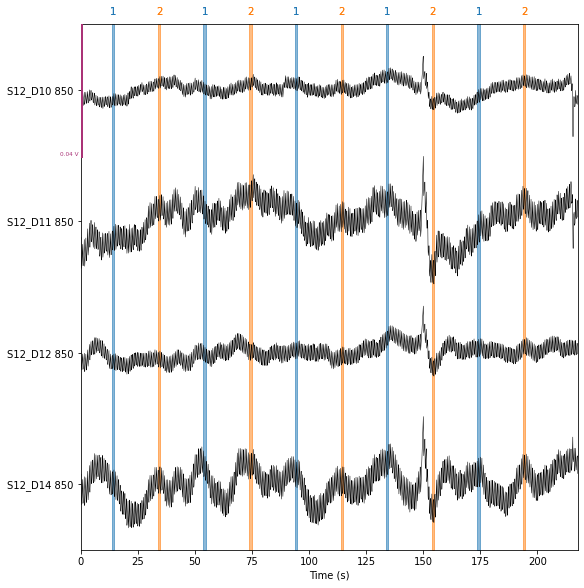

In [27]:
raw_intensity.pick_channels([ x for x in raw_intensity.ch_names if 'S12' in x and '850' in x ]).plot(n_channels=4, 
                                                                                                     duration=250, 
                                                                                                     show_scrollbars=False)
plt.show()

In [28]:
[ x for x in channels_raw.columns if 'S12' in x and '850' in x ]

['S12_D10_850', 'S12_D11_850', 'S12_D12_850', 'S12_D14_850']

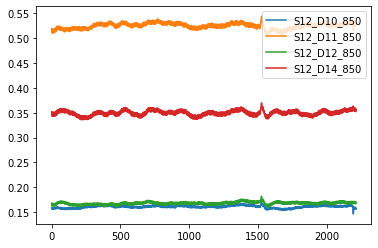

In [29]:
channels_raw[[ x for x in channels_raw.columns if 'S12' in x and '850' in x ]].plot()
plt.show()

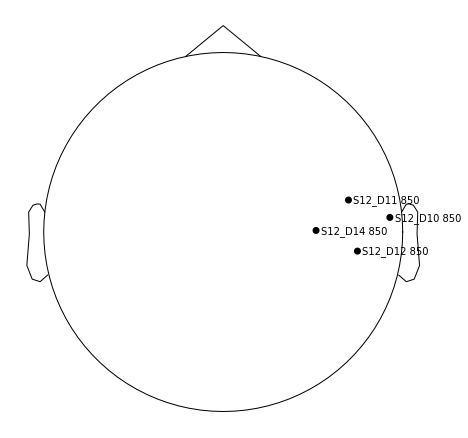

In [42]:
raw_intensity.plot_sensors(show_names=True)
plt.show()